## Домашнее задание 3

Реализуйте в функции *swing_up_feedback* управление, стабилизирующее обратный маятник в верхнем положении равновесия.

Функцию *visualize_function_3D* можно использовать для визуализации контроллера, который у вас получился.

Опишите, как вы рассуждали, пытаясь реализовать стабилиз

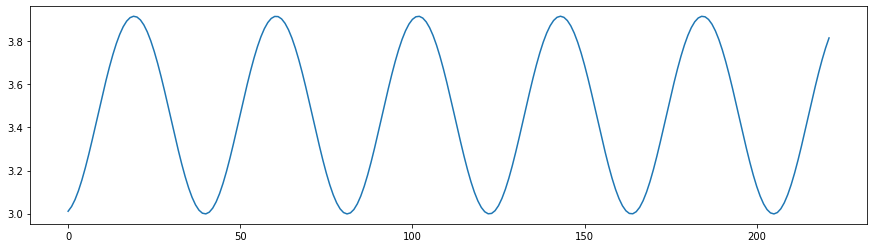

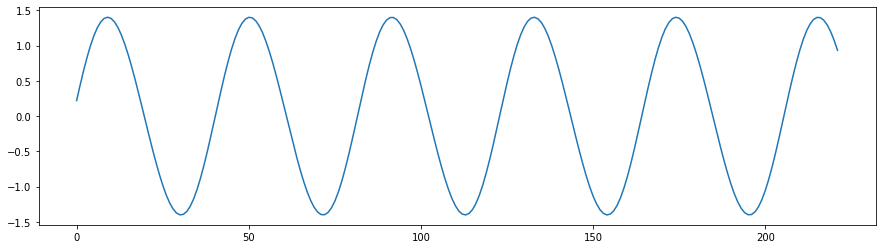

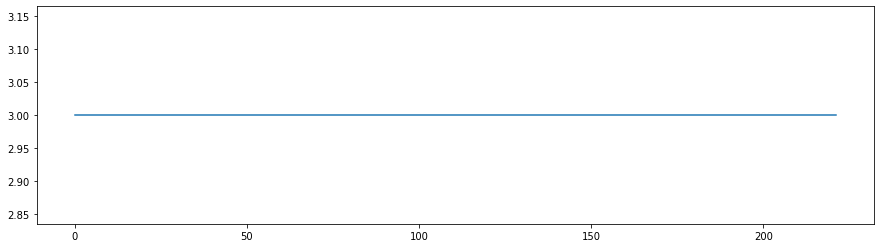

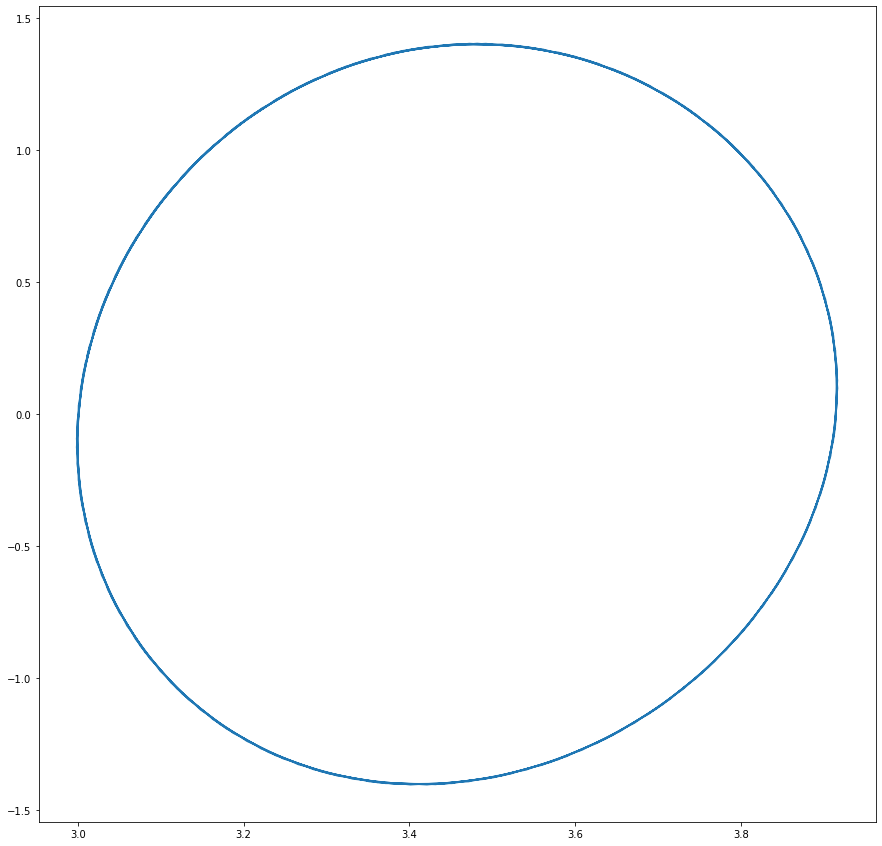

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import math

def plot_1d(data):
    plt.figure(figsize=(15, 4))
    plt.plot(data)
    plt.show()

class Weak_inverted_pendulum:
    def __init__(self, m = 1.0, l = 1.0, g = 10.0, x0 = 3, v0 = 0.0, dt = 0.05,
                 A0 = np.array([[0, 1],
                                [0, 0]]),
                 max_tau = 3):
        self.m = m
        self.l = l
        self.g = g
        self.max_tau = max_tau
        
        self.x = np.array([[x0], [v0]])
        self.dt = dt
        
        #state transition function
        self.A = A0
        self.A[1, 0] = self.g / self.l
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [1.0 / (self.m * self.l**2)]])
        
    def get_state(self):        
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        u_effective = np.clip(u, -self.max_tau, self.max_tau)

        x_dot = copy.deepcopy(self.x)
        x_dot[1] = self.g / self.l * math.sin(self.x[0]) + \
            u_effective / (self.m *self.l**2)
        
        x_dot[0] = self.x[1]
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        #self.x = self.x + sys_dyn * self.dt
        
        self.x[1] += sys_dyn[1] * self.dt
        self.x[0] += self.x[1] * self.dt

def draw_pendulum(canvas, x, y, l, alpha, color = (123, 234, 234),
                  inverted = False):
    direction = 1
    
    if (inverted == True):
        direction = -1
    
    endpoint = (int(x - l * np.cos(alpha + direction * np.pi / 2)),
                int(y + l * np.sin(alpha + direction * np.pi / 2)))
    
    cv2.line(canvas, (x, y), endpoint, (123, 234, 234), 5)
    
    cv2.circle(canvas, endpoint, 25, color, -1)

def swing_up_feedback(x, max_tau = 5):
    #YOUR CODE BELOW

    u = 3
    
    #YOUR CODE ABOVE

    return u

def run_pendulum_episode(iter_num = 1000, visualize = True):
    if (visualize == True):
        WIND_X = 700
        WIND_Y = 700
        canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    pendulum = Weak_inverted_pendulum(x0 = 3)

    i = 0

    x_traj = []
    v_traj = []
    u_traj = []
    
    while(True):
        state = pendulum.get_state()

        control = swing_up_feedback(state, pendulum.max_tau)
        
        x_dot = pendulum.sys_dyn(control)
                
        pendulum.integrate_sys_dyn(x_dot)
        
        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control)
        
        i += 1

        if (i > iter_num):
            break

        if (visualize == True):
            canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)

            draw_pendulum(canvas, WIND_X // 2, WIND_Y // 2, 300,
                          state[0], (123, 234, 45), inverted = True)

            cv2.imshow("pendulum", canvas)

            key = cv2.waitKey(10) & 0xFF

            if (key == ord('q')):
                break
    
    if (visualize == True):
        cv2.destroyAllWindows()
        cv2.waitKey(10)
    
    return x_traj, v_traj, u_traj

x_hist, v_hist, u_hist = run_pendulum_episode(visualize = True)

plot_1d(x_hist)
plot_1d(v_hist)
plot_1d(u_hist)

plt.figure(figsize=(15, 15))
plt.plot(x_hist, v_hist)
plt.show()

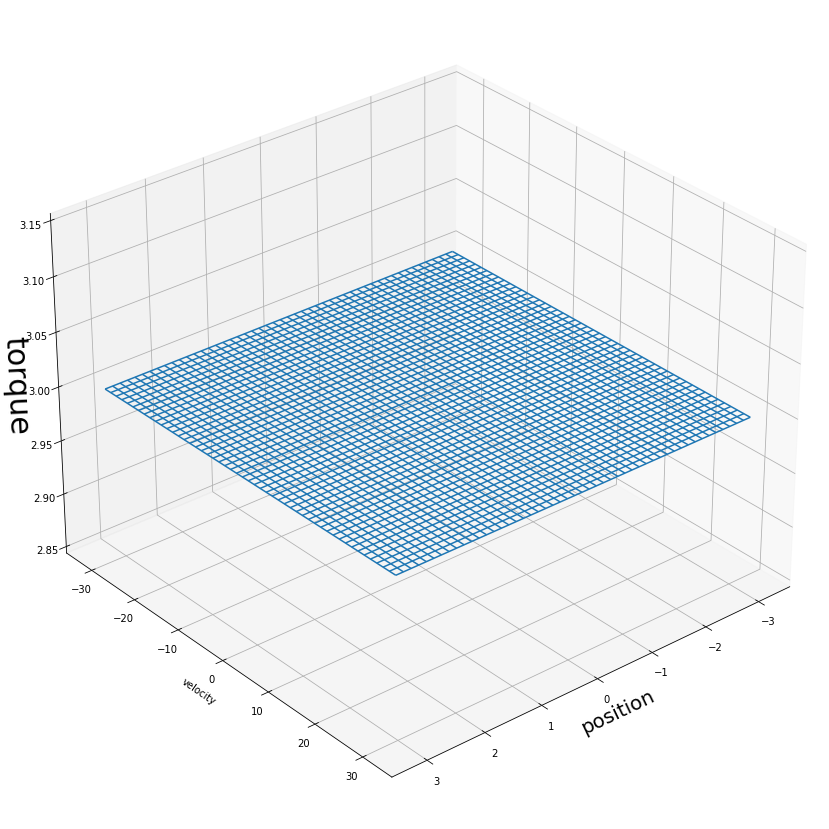

In [15]:
def visualize_function_3D(function, llim1, hlim1, a1name,
                          llim2, hlim2, a2name, pnum):
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111, projection='3d')

    X = np.linspace(llim1, hlim1, num = pnum)
    Y = np.linspace(llim2, hlim2, num = pnum)

    X, Y = np.meshgrid(X, Y)

    Z = X**2 + Y**2
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            x = X[i, j]
            y = Y[i, j]

            #print("x, y", (x, y))
            
            t = function(np.array([[x], [y]]))
            
            #t = np.clip(t, -30, 30)
            
            Z[i, j] = t
    
    ax.view_init(30, 50)
    ax.plot_wireframe(X, Y, Z)

    ax.set_xlabel(a1name, fontsize=20, rotation=150)
    ax.set_ylabel(a2name)
    ax.set_zlabel(r'torque', fontsize=30, rotation=60)
        
    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    #return data

feedbacks = [swing_up_feedback]

for feedback in feedbacks:
    visualize_function_3D(feedback, -math.pi, math.pi,
        "position", -5 * math.pi * 2, 5 * math.pi * 2, "velocity", 50)